In [6]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
# base_url will be empty if .env file is missi ng
assert base_url != ""
im_helper = ImageHelper(base_url)

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from plantcv import plantcv as pcv
import matplotlib
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

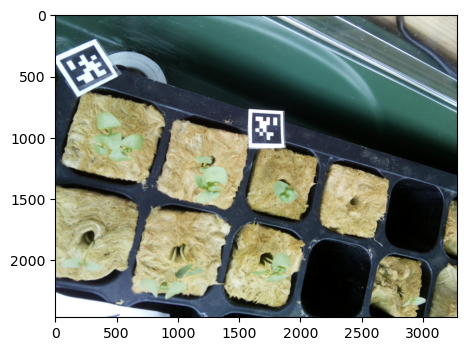

In [20]:
dt_str = '25/11/2022 17:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))

img1, path, filename = pcv.readimage(filename=im_helper.image.name)

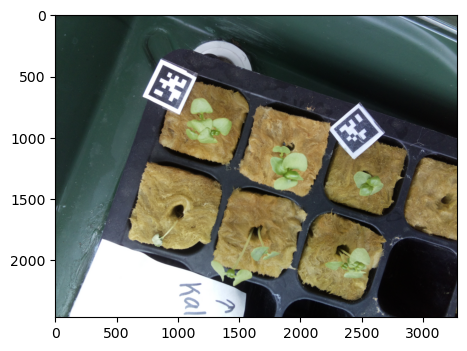

In [21]:
dt_str = '27/11/2022 17:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))

img2, path, filename = pcv.readimage(filename=im_helper.image.name)

Our goal is to be able to look at images, and normalize them to each other such that we can tell the difference in plant foliage, regardless of shots from different heights, of different croppings, from different angles. 

One approach is to use homography to map one image to another, and get the change in scale and position from the change in location of the connections between the two. In the following, we try to use homography to map one image on to another. 

In [22]:
MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [29]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h = img1.shape[0]
    w = img1.shape[1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

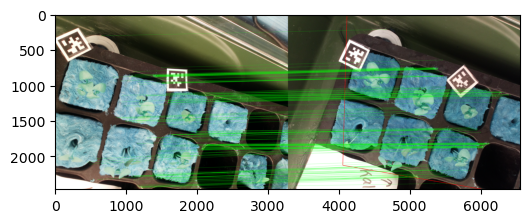

(<matplotlib.image.AxesImage at 0x7fc0986b7730>, None)

In [32]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()